In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
from scipy.stats.mstats import winsorize

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV

import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

## Load the houseprices data from Thinkful's database

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
houseprices = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()


## Do data cleaning, exploratory data analysis, and feature engineering. 

In [3]:
houseprices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

In [4]:
houseprices.describe()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,1460.000,1460.000,1201.000,1460.000,1460.000,1460.000,1460.000,1460.000,1452.000,1460.000,...,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000
mean,730.500,56.897,70.050,10516.828,6.099,5.575,1971.268,1984.866,103.685,443.640,...,94.245,46.660,21.954,3.410,15.061,2.759,43.489,6.322,2007.816,180921.196
std,421.610,42.301,24.285,9981.265,1.383,1.113,30.203,20.645,181.066,456.098,...,125.339,66.256,61.119,29.317,55.757,40.177,496.123,2.704,1.328,79442.503
min,1.000,20.000,21.000,1300.000,1.000,1.000,1872.000,1950.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,2006.000,34900.000
25%,365.750,20.000,59.000,7553.500,5.000,5.000,1954.000,1967.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,2007.000,129975.000
50%,730.500,50.000,69.000,9478.500,6.000,5.000,1973.000,1994.000,0.000,383.500,...,0.000,25.000,0.000,0.000,0.000,0.000,0.000,6.000,2008.000,163000.000
75%,1095.250,70.000,80.000,11601.500,7.000,6.000,2000.000,2004.000,166.000,712.250,...,168.000,68.000,0.000,0.000,0.000,0.000,0.000,8.000,2009.000,214000.000
max,1460.000,190.000,313.000,215245.000,10.000,9.000,2010.000,2010.000,1600.000,5644.000,...,857.000,547.000,552.000,508.000,480.000,738.000,15500.000,12.000,2010.000,755000.000


In [5]:
houseprices.isnull().sum()*100/1460

id               0.000
mssubclass       0.000
mszoning         0.000
lotfrontage     17.740
lotarea          0.000
street           0.000
alley           93.767
lotshape         0.000
landcontour      0.000
utilities        0.000
lotconfig        0.000
landslope        0.000
neighborhood     0.000
condition1       0.000
condition2       0.000
bldgtype         0.000
housestyle       0.000
overallqual      0.000
overallcond      0.000
yearbuilt        0.000
yearremodadd     0.000
roofstyle        0.000
roofmatl         0.000
exterior1st      0.000
exterior2nd      0.000
masvnrtype       0.548
masvnrarea       0.548
exterqual        0.000
extercond        0.000
foundation       0.000
                 ...  
bedroomabvgr     0.000
kitchenabvgr     0.000
kitchenqual      0.000
totrmsabvgrd     0.000
functional       0.000
fireplaces       0.000
fireplacequ     47.260
garagetype       5.548
garageyrblt      5.548
garagefinish     5.548
garagecars       0.000
garagearea       0.000
garagequal 

In [6]:
#looking at the percentage of null values in some of the columns we can drop them outright.
houseprices = houseprices.drop(['alley', 
                                'fireplacequ', 
                                'poolqc', 
                                'fence', 
                                'miscfeature'], axis=1)

In [7]:
list(houseprices.select_dtypes(exclude='object'))

['id',
 'mssubclass',
 'lotfrontage',
 'lotarea',
 'overallqual',
 'overallcond',
 'yearbuilt',
 'yearremodadd',
 'masvnrarea',
 'bsmtfinsf1',
 'bsmtfinsf2',
 'bsmtunfsf',
 'totalbsmtsf',
 'firstflrsf',
 'secondflrsf',
 'lowqualfinsf',
 'grlivarea',
 'bsmtfullbath',
 'bsmthalfbath',
 'fullbath',
 'halfbath',
 'bedroomabvgr',
 'kitchenabvgr',
 'totrmsabvgrd',
 'fireplaces',
 'garageyrblt',
 'garagecars',
 'garagearea',
 'wooddecksf',
 'openporchsf',
 'enclosedporch',
 'threessnporch',
 'screenporch',
 'poolarea',
 'miscval',
 'mosold',
 'yrsold',
 'saleprice']

In [8]:
numeric_variables = ['mssubclass',
                     'lotfrontage',
                     'lotarea',
                     'overallqual',
                     'overallcond',
                     'yearbuilt',
                     'yearremodadd',
                     'masvnrarea',
                     'bsmtfinsf1',
                     'bsmtfinsf2',
                     'bsmtunfsf',
                     'totalbsmtsf',
                     'firstflrsf',
                     'secondflrsf',
                     'lowqualfinsf',
                     'grlivarea',
                     'bsmtfullbath',
                     'bsmthalfbath',
                     'fullbath',
                     'halfbath',
                     'bedroomabvgr',
                     'kitchenabvgr',
                     'totrmsabvgrd',
                     'fireplaces',
                     'garageyrblt',
                     'garagecars',
                     'garagearea',
                     'wooddecksf',
                     'openporchsf',
                     'enclosedporch',
                     'threessnporch',
                     'screenporch',
                     'poolarea',
                     'miscval',
                     'mosold',
                     'yrsold',
                     'saleprice']

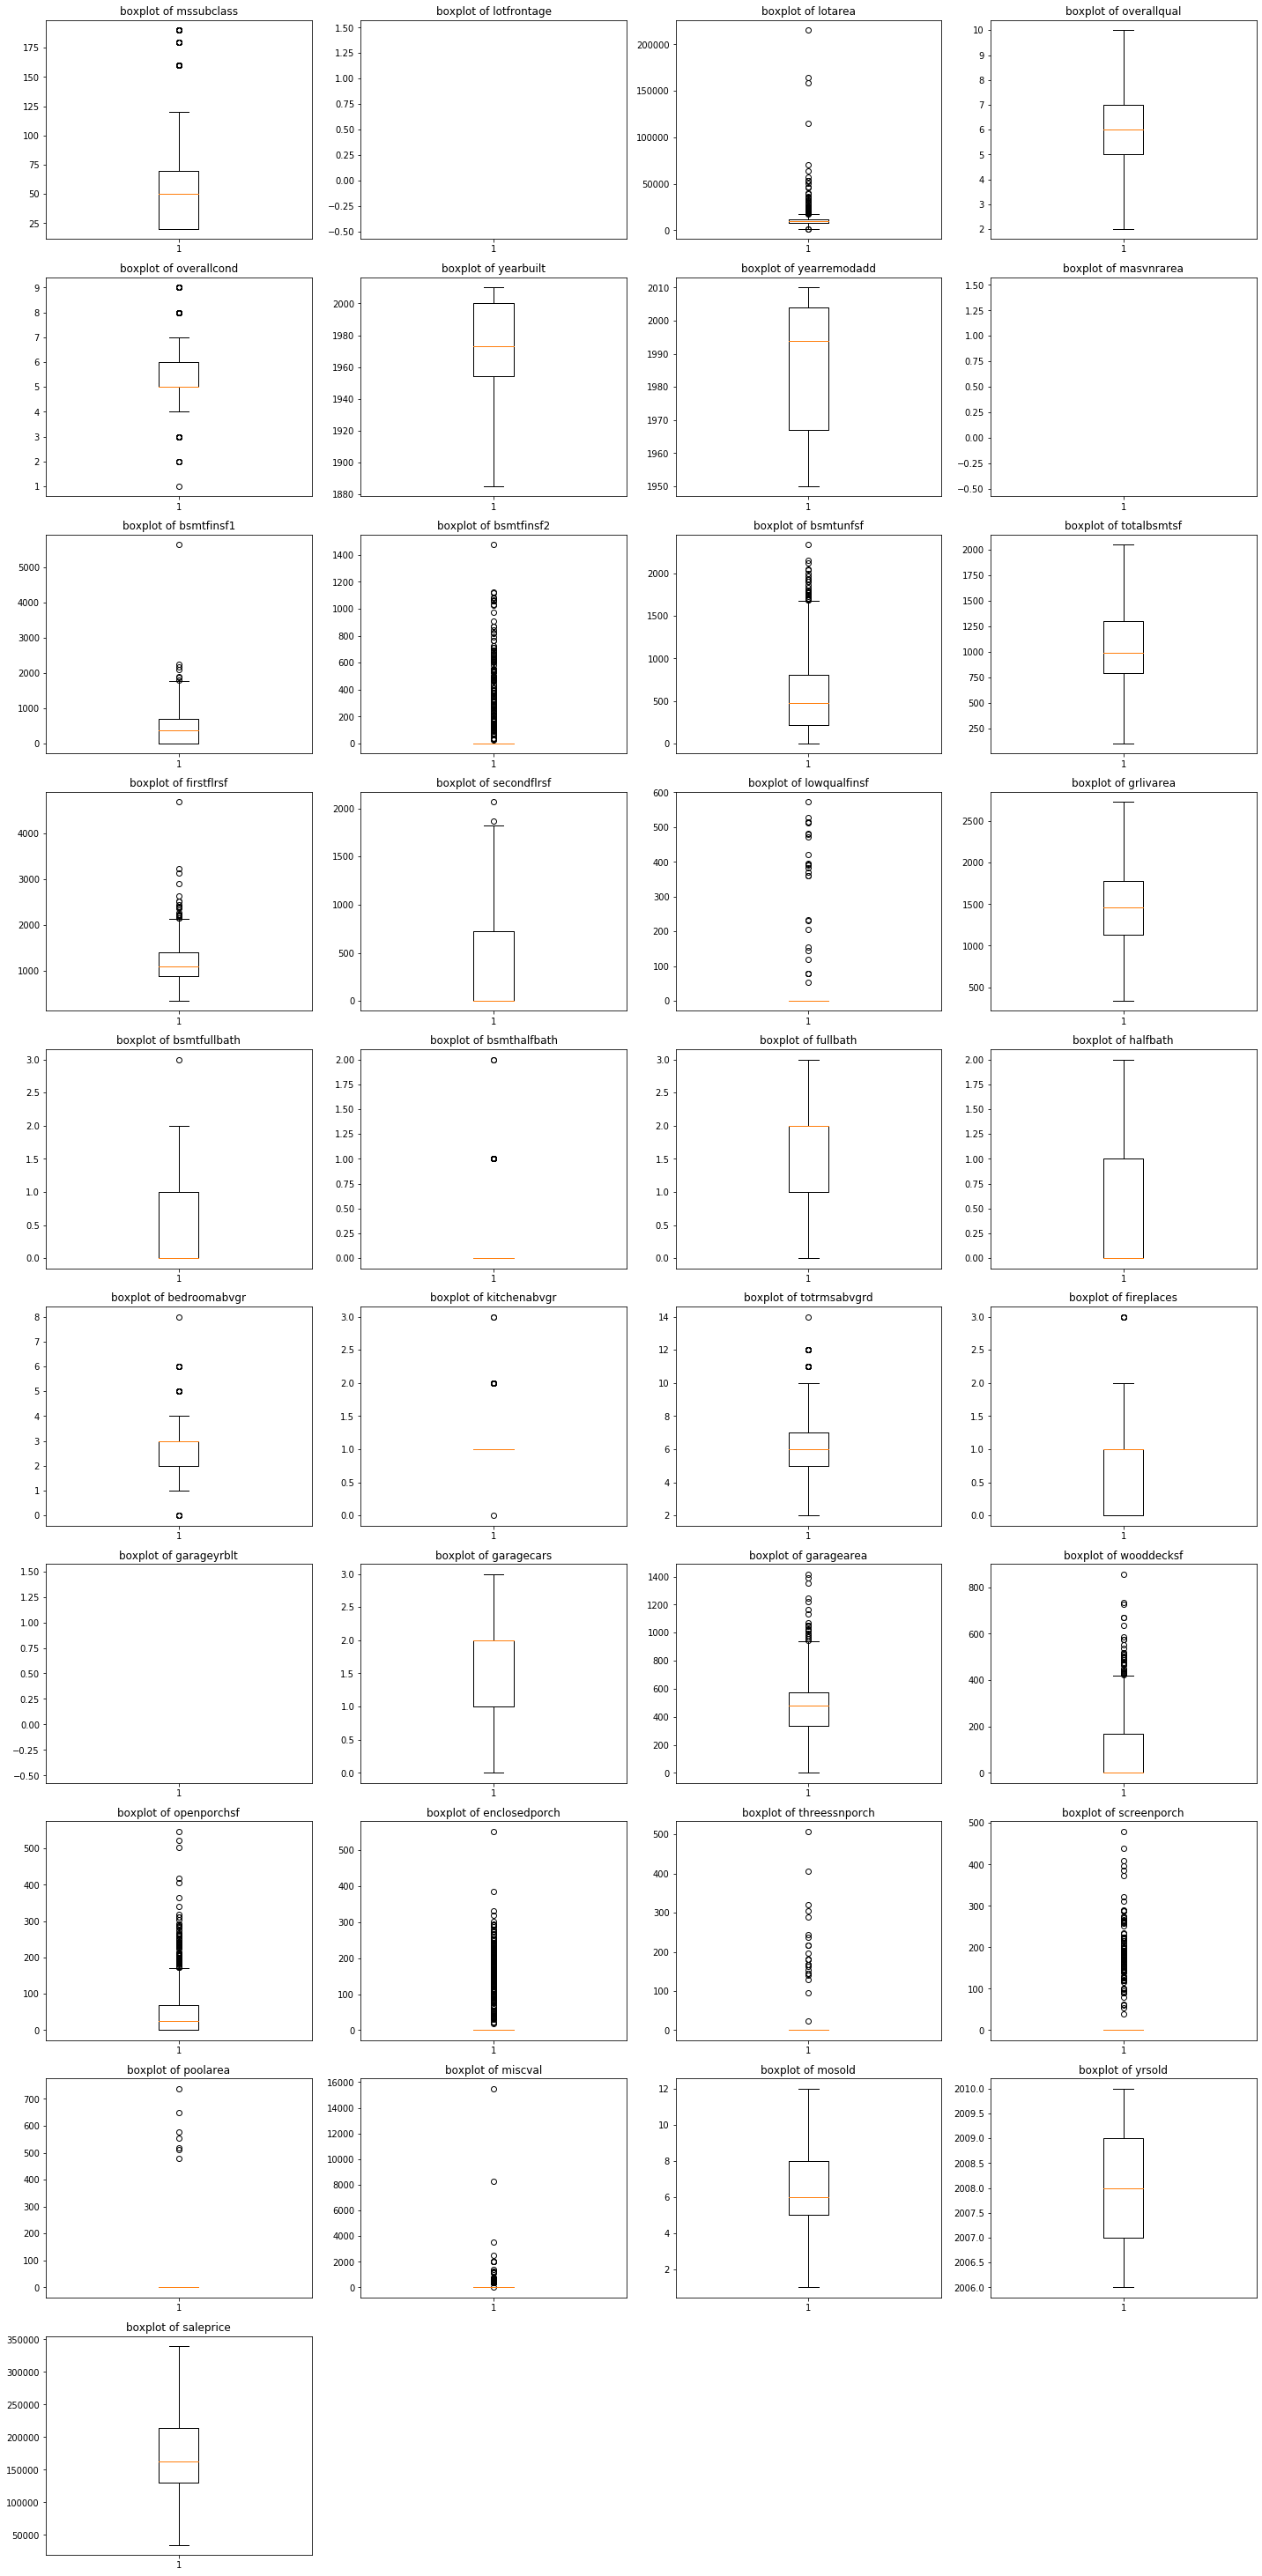

In [31]:
fig = plt.figure(figsize=(20,150))
for i, col in enumerate(numeric_variables):
    
    plt.subplot(len(numeric_variables), 4, i+1)
    plt.boxplot(houseprices[col])
    plt.title('boxplot of {}'.format(col))
    plt.tight_layout()

In [10]:
#look at a heatmap to start finding features
for col in numeric_variables:
    q75, q25 = np.percentile(houseprices[col], [75 ,25])
    iqr = q75 - q25

    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    print("Number of outliers and percentage of it in {} : {} and %{}".format(col,
                                                                             len((np.where((houseprices[col] > max_val) | 
                                                                                           (houseprices[col] < min_val))[0])),len((np.where((houseprices[col] > max_val) | 
                                                                                           (houseprices[col] < min_val))[0]))*100/1460))

Number of outliers and percentage of it in mssubclass : 103 and %7.054794520547945
Number of outliers and percentage of it in lotfrontage : 0 and %0.0
Number of outliers and percentage of it in lotarea : 69 and %4.726027397260274
Number of outliers and percentage of it in overallqual : 2 and %0.136986301369863
Number of outliers and percentage of it in overallcond : 125 and %8.561643835616438
Number of outliers and percentage of it in yearbuilt : 7 and %0.4794520547945205
Number of outliers and percentage of it in yearremodadd : 0 and %0.0
Number of outliers and percentage of it in masvnrarea : 0 and %0.0
Number of outliers and percentage of it in bsmtfinsf1 : 7 and %0.4794520547945205
Number of outliers and percentage of it in bsmtfinsf2 : 167 and %11.438356164383562
Number of outliers and percentage of it in bsmtunfsf : 29 and %1.9863013698630136
Number of outliers and percentage of it in totalbsmtsf : 61 and %4.178082191780822
Number of outliers and percentage of it in firstflrsf : 

In [11]:
#the amount of outliers is relatively small so I'll check a heatmap to see which 
#variables can be dropped outright
print(houseprices[numeric_variables].iloc[:, :].corr(
).loc[:, 'saleprice'].sort_values(ascending=False)
)
#I will take the top ten and start to whittle my way down


saleprice        1.000
overallqual      0.791
grlivarea        0.709
garagecars       0.640
garagearea       0.623
totalbsmtsf      0.614
firstflrsf       0.606
fullbath         0.561
totrmsabvgrd     0.534
yearbuilt        0.523
yearremodadd     0.507
garageyrblt      0.486
masvnrarea       0.477
fireplaces       0.467
bsmtfinsf1       0.386
lotfrontage      0.352
wooddecksf       0.324
secondflrsf      0.319
openporchsf      0.316
halfbath         0.284
lotarea          0.264
bsmtfullbath     0.227
bsmtunfsf        0.214
bedroomabvgr     0.168
screenporch      0.111
poolarea         0.092
mosold           0.046
threessnporch    0.045
bsmtfinsf2      -0.011
bsmthalfbath    -0.017
miscval         -0.021
lowqualfinsf    -0.026
yrsold          -0.029
overallcond     -0.078
mssubclass      -0.084
enclosedporch   -0.129
kitchenabvgr    -0.136
Name: saleprice, dtype: float64


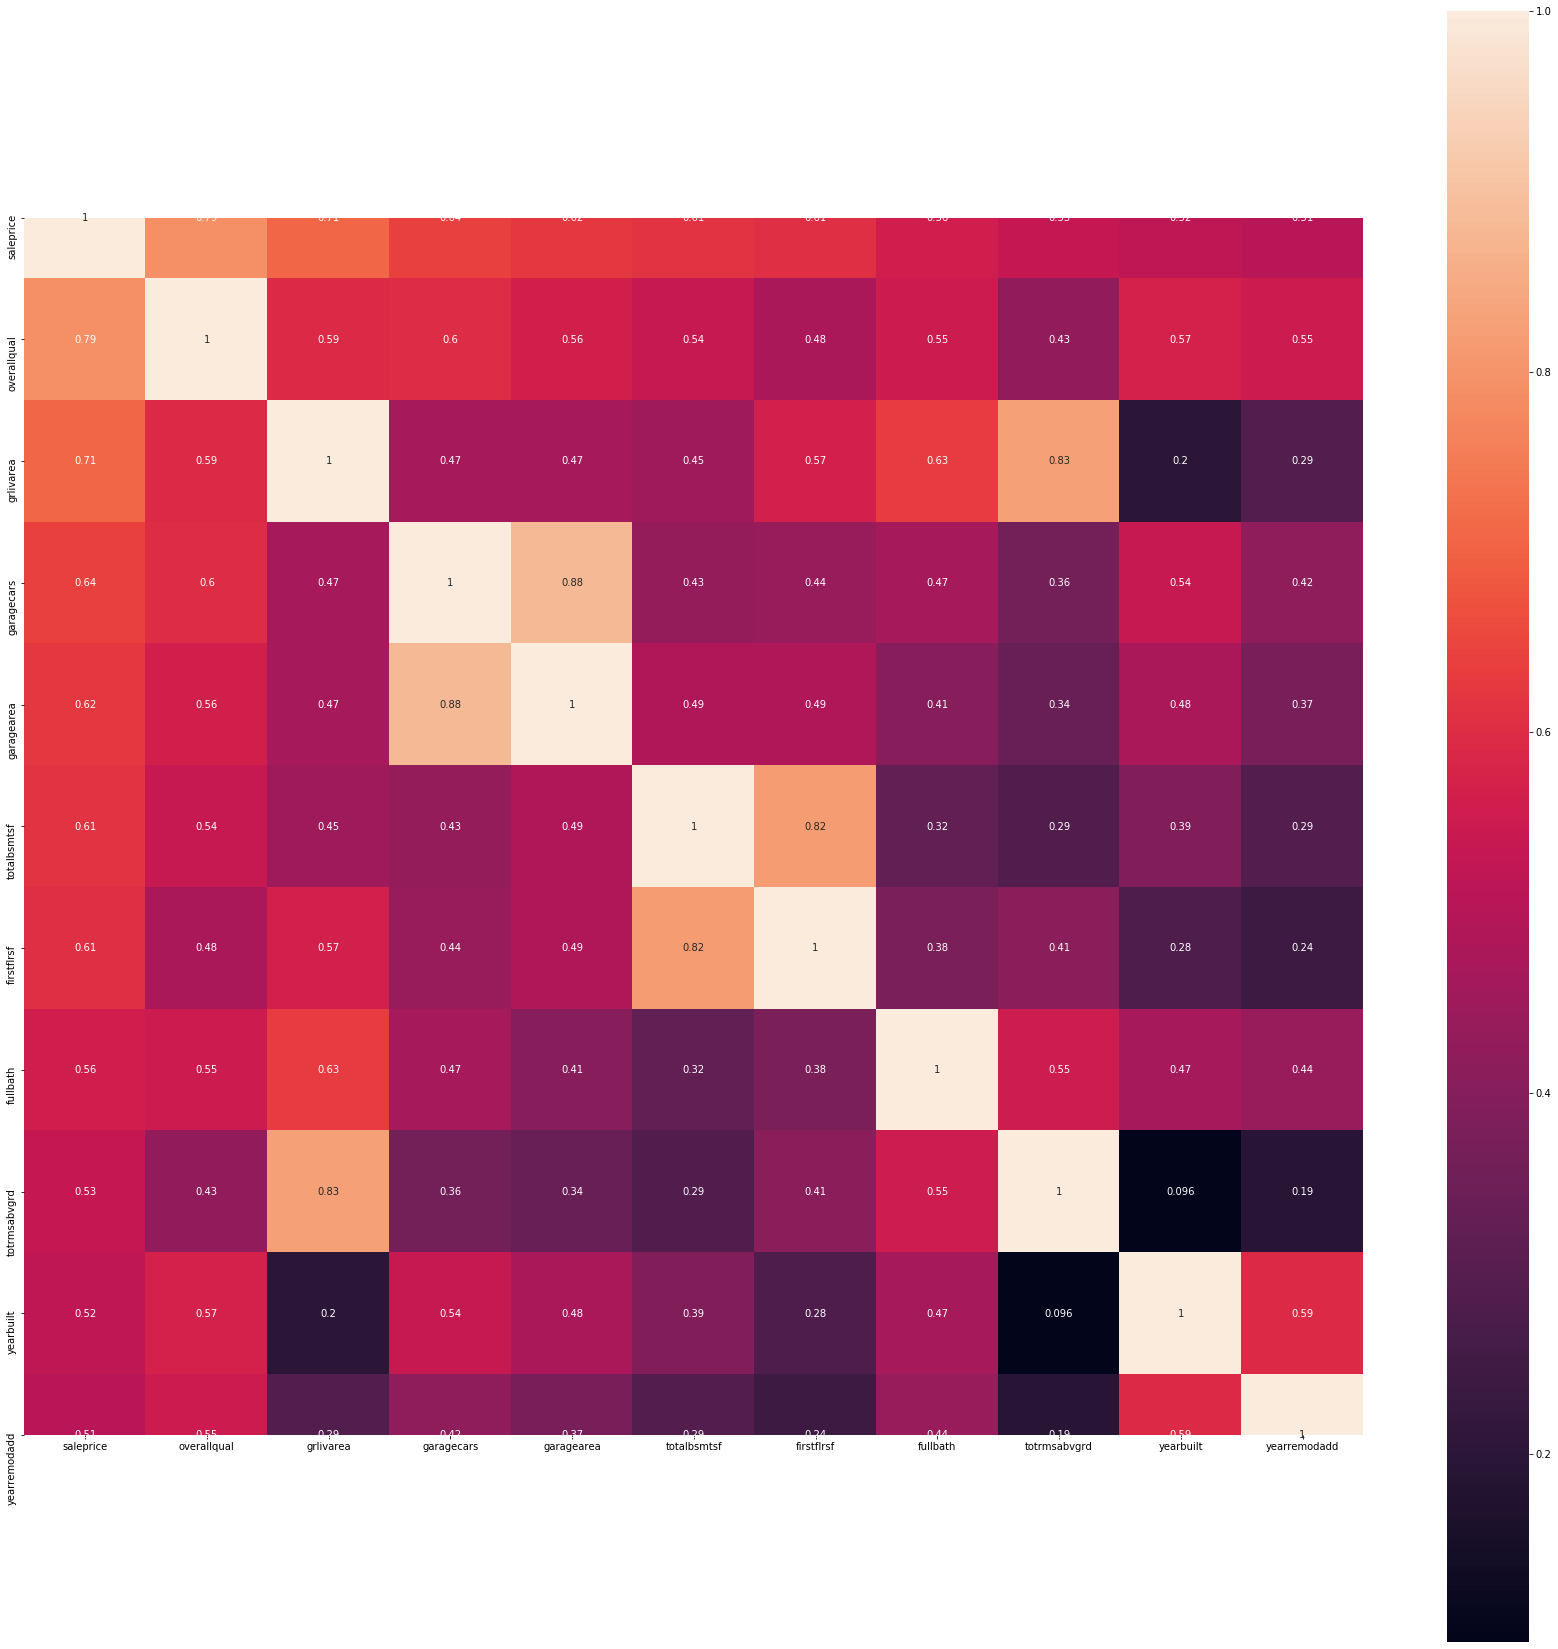

In [12]:
top_ten = houseprices[['saleprice',
                       'overallqual',
                       'grlivarea',
                       'garagecars',
                       'garagearea',
                       'totalbsmtsf',
                       'firstflrsf',
                       'fullbath',
                       'totrmsabvgrd',
                       'yearbuilt',
                       'yearremodadd']]

plt.figure(figsize=(30, 30))
sns.heatmap(top_ten.corr(), square=True, annot=True)

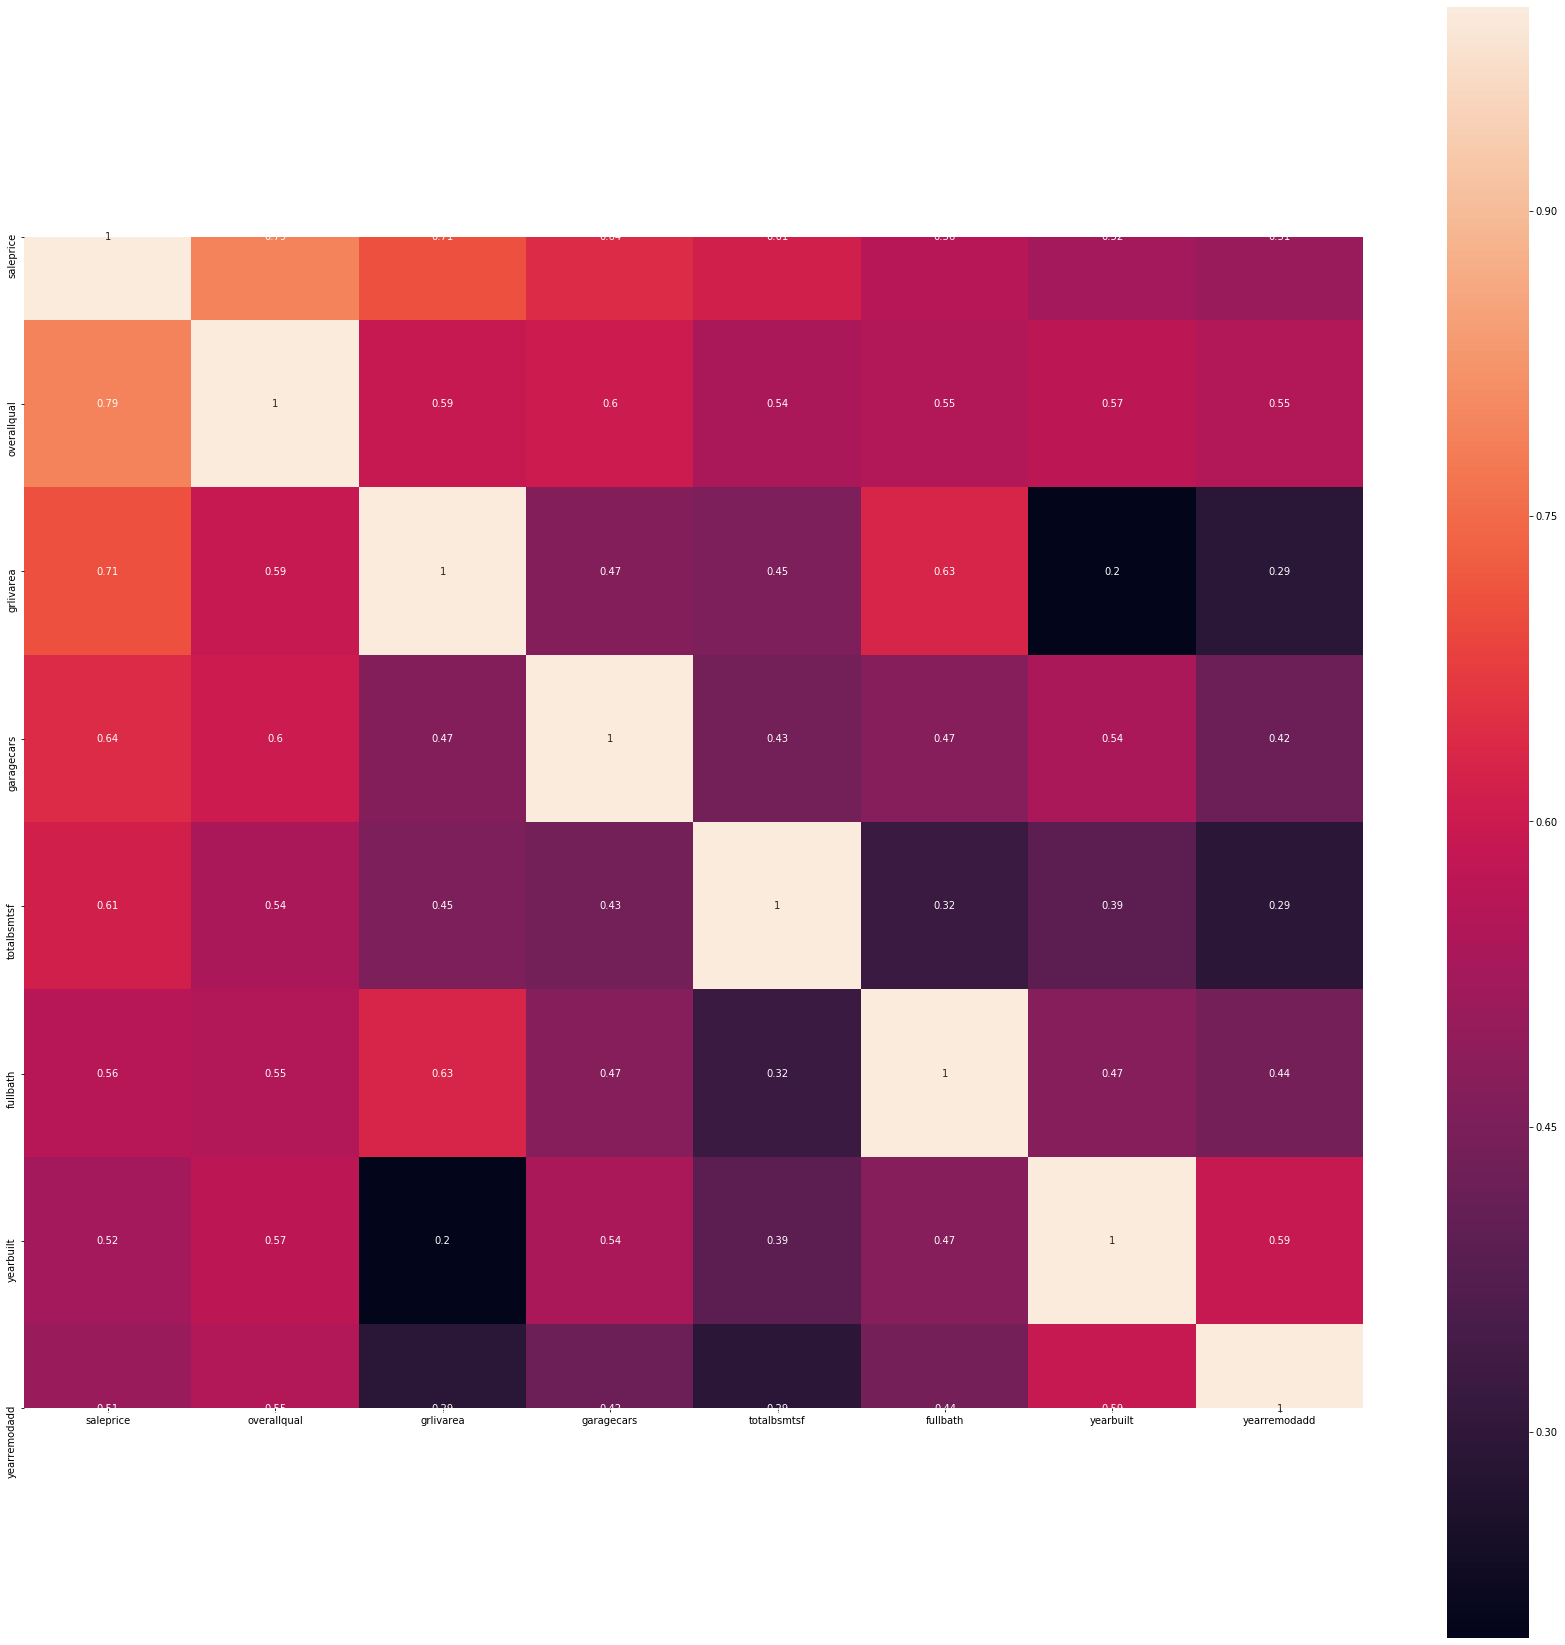

In [13]:
# all top_ten variables have over 50% correlation with our target but some
# are too highly correlated with each other
# we can drop garagearea, totrmsabvgrd and firstflrsf
top_seven = houseprices[['saleprice',
                         'overallqual',
                         'grlivarea',
                         'garagecars',
                         'totalbsmtsf',
                         'fullbath',
                         'yearbuilt',
                         'yearremodadd']]
plt.figure(figsize=(30,30))
sns.heatmap(top_seven.corr(), square=True, annot=True)

In [14]:
#check for outliers in top_seven
#look at a heatmap to start finding features
for col in top_seven:
    q75, q25 = np.percentile(top_seven[col], [75 ,25])
    iqr = q75 - q25

    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    print("Number of outliers and percentage of it in {} : {} and %{}".format(col,
                                                                             len((np.where((top_seven[col] > max_val) | 
                                                                                           (top_seven[col] < min_val))[0])),len((np.where((top_seven[col] > max_val) | 
                                                                                           (top_seven[col] < min_val))[0]))*100/1460))
    
    
    print('percent of outliers low')
    print(len(np.where(top_seven[col] < min_val)[0]) /1460)
    print('Percent of outliers high')
    print(len(np.where(top_seven[col] > max_val)[0]) /1460)
    print(90 * '-')

Number of outliers and percentage of it in saleprice : 61 and %4.178082191780822
percent of outliers low
0.0
Percent of outliers high
0.04178082191780822
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in overallqual : 2 and %0.136986301369863
percent of outliers low
0.0013698630136986301
Percent of outliers high
0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in grlivarea : 31 and %2.1232876712328768
percent of outliers low
0.0
Percent of outliers high
0.021232876712328767
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in garagecars : 5 and %0.3424657534246575
percent of outliers low
0.0
Percent of outliers high
0.003424657534246575
------------------------------------------------------------------------------------------
Number of out

In [15]:
#deal with outlier values using winsorization
houseprices['saleprice'] = winsorize(houseprices['saleprice'], (0, 0.04178082191780822))
houseprices['overallqual'] = winsorize(houseprices['overallqual'], (0.0013698630136986301, 0))
houseprices['grlivarea'] = winsorize(houseprices['grlivarea'], (0, 0.021232876712328767))
houseprices['garagecars'] = winsorize(houseprices['garagecars'], (0, 0.003424657534246575))
houseprices['totalbsmtsf'] = winsorize(houseprices['totalbsmtsf'], (0.025342465753424658, 0.017))
houseprices['yearbuilt'] = winsorize(houseprices['yearbuilt'], (0.004794520547945206, 0))

In [16]:
for col in top_seven:
    q75, q25 = np.percentile(houseprices[col], [75 ,25])
    iqr = q75 - q25

    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    print("Number of outliers and percentage of it in {} : {} and %{}".format(col,
                                                                             len((np.where((houseprices[col] > max_val) | 
                                                                                           (houseprices[col] < min_val))[0])),len((np.where((houseprices[col] > max_val) | 
                                                                                           (houseprices[col] < min_val))[0]))*100/1460))
    
    
    print('percent of outliers low')
    print(len(np.where(houseprices[col] < min_val)[0]) /1460)
    print('Percent of outliers high')
    print(len(np.where(houseprices[col] > max_val)[0]) /1460)
    print(90 * '-')

Number of outliers and percentage of it in saleprice : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in overallqual : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in grlivarea : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in garagecars : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in totalbsmtsf : 0 and %0.0
percent of outliers low
0.0
Percent of outliers high
0.0
----------------

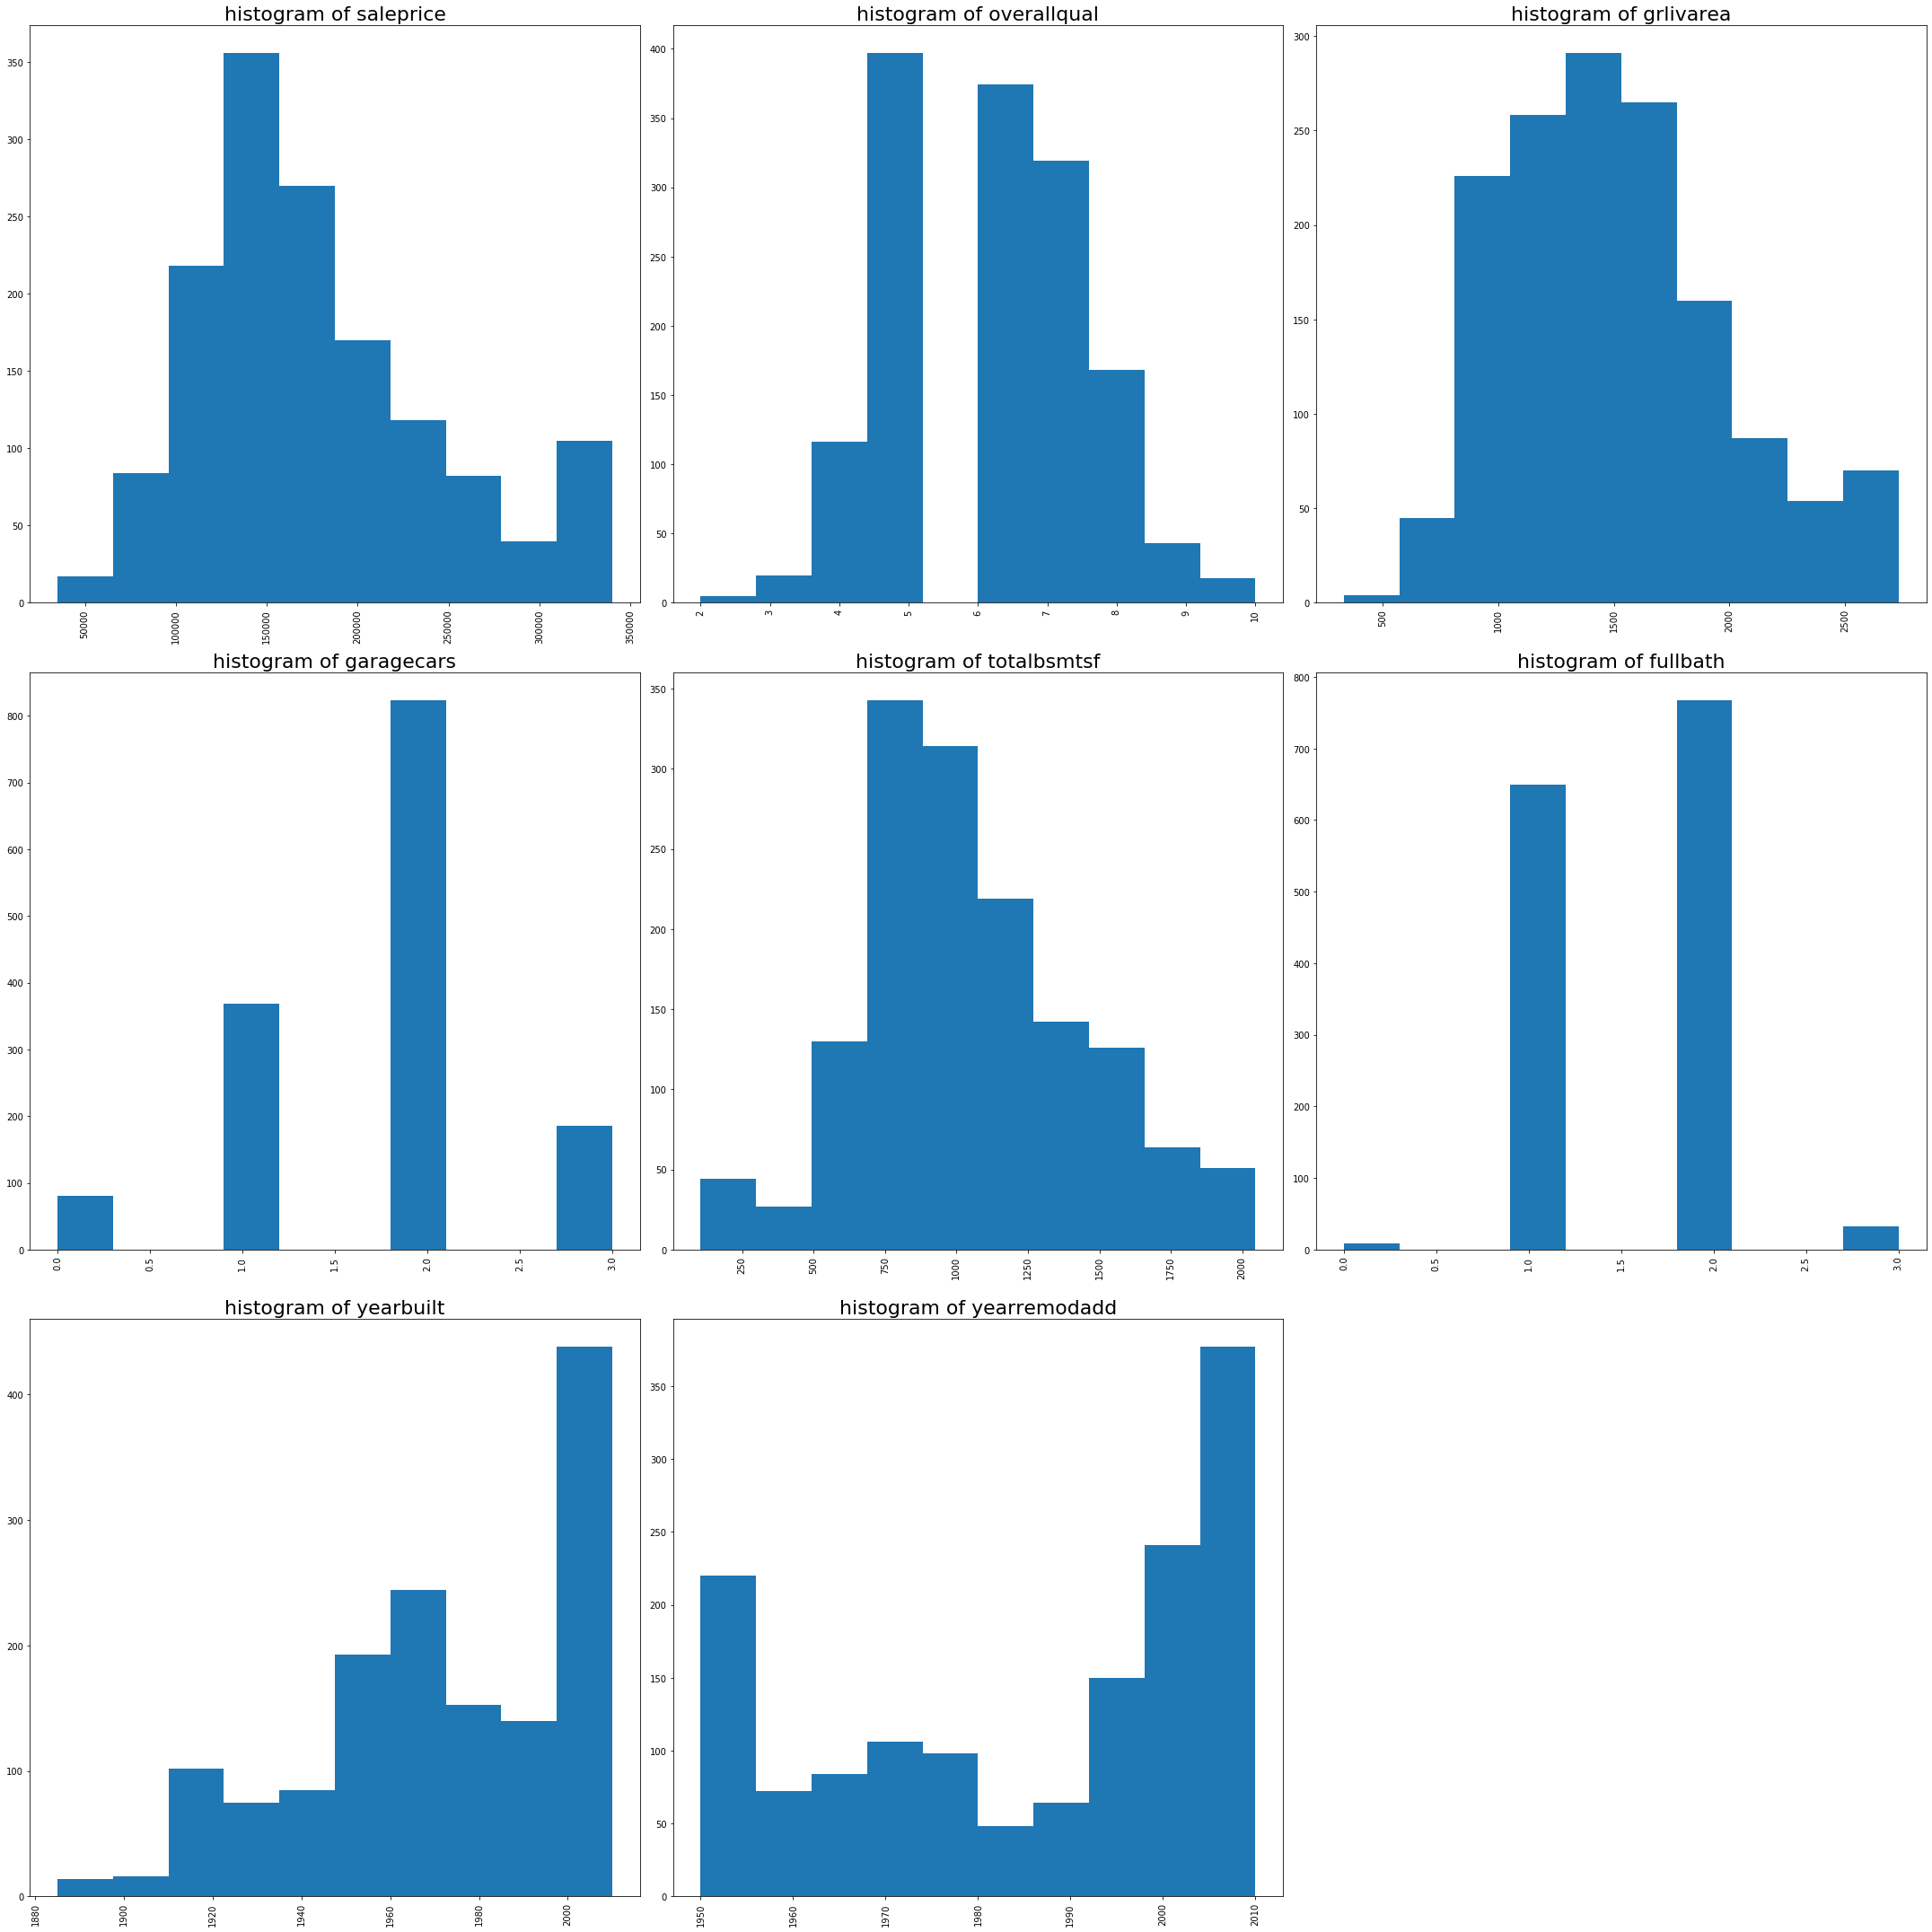

In [17]:
#visually checking for normality
plt.figure(figsize=(30,30))
for i, col in enumerate(top_seven):
    plt.subplot(3, 3, i+1)
    plt.hist(houseprices[col])
    plt.title('histogram of {}'.format(col), fontsize=22)
    plt.xticks(rotation='vertical')
    plt.tight_layout()


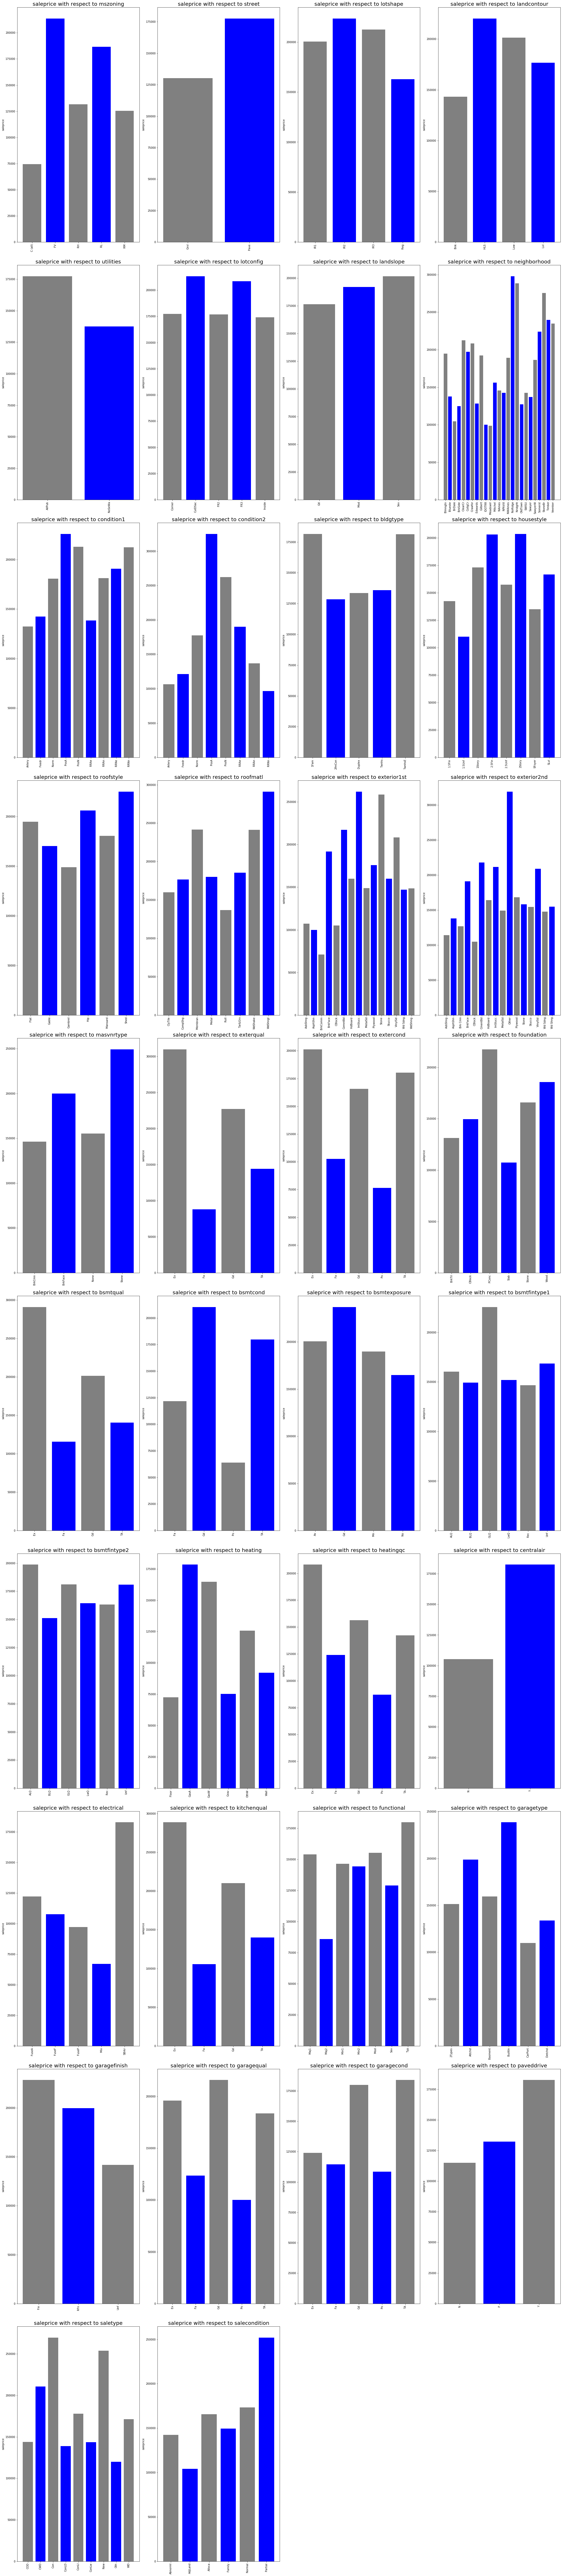

In [18]:
#a couple of our variables look relatively normal
#for now I'll take a look at our non numeric columns 
object_columns = list(houseprices.select_dtypes('object'))

plt.figure(figsize=(30, 150))
for i, col in enumerate(object_columns):
    plt.subplot(11, 4, i+1)
    plt.bar(houseprices.groupby(col)['saleprice'].mean(
    ).index, houseprices.groupby(col)['saleprice'].mean(), color=('grey', 'blue'))
    plt.ylabel('saleprice')
    plt.xticks(rotation='vertical')
    plt.title('saleprice with respect to {}'.format(col), fontsize=20)
    plt.tight_layout()

Looking at the object columns with respect to saleprice, some of them stand out. I'll make dummies of centralair, kitchenqual, and street.

In [34]:
houseprices = pd.concat([houseprices, pd.get_dummies(houseprices.street, drop_first=True, prefix='street')], axis=1)
houseprices = pd.concat([houseprices, pd.get_dummies(houseprices.centralair, drop_first=True, prefix='centralair')], axis=1)
houseprices = pd.concat([houseprices, pd.get_dummies(houseprices.kitchenqual, drop_first=True, prefix='kithcenqual')], axis=1)

dummy_columns = list(pd.get_dummies(houseprices.street, drop_first=True, prefix='street').columns)
dummy_columns = dummy_columns + list(pd.get_dummies(houseprices.centralair, drop_first=True, prefix='centralair').columns)
dummy_columns = dummy_columns + list(pd.get_dummies(houseprices.kitchenqual, drop_first=True, prefix='kithcenqual').columns)


In [20]:
# testing ols on our first set of features
Y = houseprices['saleprice']

X = houseprices[['overallqual',
                 'grlivarea',
                 'garagecars',
                 'totalbsmtsf',
                 'fullbath',
                 'yearbuilt',
                 'yearremodadd'] + dummy_columns]

#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     685.9
Date:                Thu, 31 Oct 2019   Prob (F-statistic):               0.00
Time:                        18:24:16   Log-Likelihood:                -16912.
No. Observations:                1460   AIC:                         3.385e+04
Df Residuals:                    1447   BIC:                         3.392e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -9.811e+05   1.03e+05     -9.564      0.000   -1.18e+06    -7.8e+05
overallqual     1.222e+04    865.340     14.120      0.000    1.05e+04    1.39e+04
grlivarea         52.7841      2.225     23.726      0.000      48.420      57.148
garagecars      1.109e+04   1295.055      8.564      0.000    8550.683    1.36e+04
totalbsmtsf       32.2072      2.170     14.839      0.000      27.950      36.465
fullbath       -6774.2720   1848.424     -3.665      0.000   -1.04e+04   -3148.396
yearbuilt        260.0039     35.593      7.305      0.000     190.185     329.823
yearremodadd     233.9566     48.091      4.865      0.000     139.622     328.291
street_Pave     2279.0805   1.08e+04      0.211      0.833   -1.89e+04    2.34e+04
centralair_Y    8784.3758   3141.553      2.796      0.005    2621.889    1.49e+04
kithcenqual_Fa -2.562e+04   5855.201     -4.375      0.000   -3.71e+04   -1.41e+04
kithcenqual_Gd -2.182e+04   3061.526     -7.126      0.000   -2.78e+04   -1.58e+04
kithcenqual_TA -3.234e+04   3590.571     -9.008      0.000   -3.94e+04   -2.53e+04
==============================================================================
Omnibus:                      214.854   Durbin-Watson:                   2.058
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1774.097
Skew:                          -0.411   Prob(JB):                         0.00
Kurtosis:                       8.337   Cond. No.                     5.05e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.05e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [21]:
#sreet_Pave doesn't have any statistical significance to the model so we'll drop it
dummy_columns_two = list(pd.get_dummies(houseprices.centralair, drop_first=True, prefix='centralair').columns)
dummy_columns = dummy_columns_two + list(pd.get_dummies(houseprices.kitchenqual, drop_first=True, prefix='kithcenqual').columns)

# testing ols on our first set of features
Y2 = houseprices['saleprice']

X2 = houseprices[['overallqual',
                 'grlivarea',
                 'garagecars',
                 'totalbsmtsf',
                 'fullbath',
                 'yearbuilt',
                 'yearremodadd'] + dummy_columns_two]

#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)
X2 = sm.add_constant(X2)

results = sm.OLS(Y2, X2).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     964.6
Date:                Thu, 31 Oct 2019   Prob (F-statistic):               0.00
Time:                        18:24:16   Log-Likelihood:                -16954.
No. Observations:                1460   AIC:                         3.393e+04
Df Residuals:                    1451   BIC:                         3.397e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.259e+06   9.31e+04    -13.518      0.000   -1.44e+06   -1.08e+06
overallqual   1.472e+04    840.842     17.504      0.000    1.31e+04    1.64e+04
grlivarea       54.0022      2.281     23.670      0.000      49.527      58.477
garagecars     1.15e+04   1317.125      8.728      0.000    8912.638    1.41e+04
totalbsmtsf     34.8182      2.202     15.809      0.000      30.498      39.139
fullbath     -7764.5114   1887.129     -4.114      0.000   -1.15e+04   -4062.719
yearbuilt      265.6966     36.397      7.300      0.000     194.301     337.092
yearremodadd   348.5454     45.240      7.704      0.000     259.802     437.289
centralair_Y  5361.4356   3128.091      1.714      0.087    -774.627    1.15e+04
==============================================================================
Omnibus:                      173.313   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1037.004
Skew:                          -0.369   Prob(JB):                    6.57e-226
Kurtosis:                       7.062   Cond. No.                     4.46e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.46e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one!


The number of observations in training set is 1168
The number of observations in test set is 292


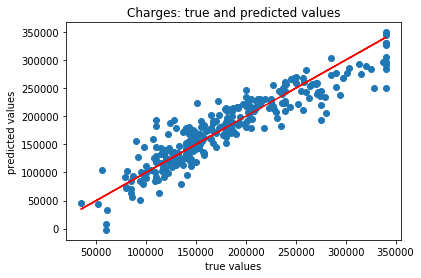

Mean absolute error of the prediction is: 19703.150563435116
Mean squared error of the prediction is: 673562571.7886575
Root mean squared error of the prediction is: 25953.08405158542
Mean absolute percentage error of the prediction is: 12.654650590069014


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X2, Y2, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

# We add constant to the model as it's a best practice
# to do so every time!
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))



In [23]:
#same model with the target variable log_transformed
houseprices['log_saleprice'] = np.log(houseprices['saleprice'])

Y3 = houseprices['log_saleprice']

X3 = houseprices[['overallqual',
                 'grlivarea',
                 'garagecars',
                 'totalbsmtsf',
                 'fullbath',
                 'yearbuilt',
                 'yearremodadd'] + dummy_columns_two]

#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)
X3 = sm.add_constant(X3)

results = sm.OLS(Y3, X3).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log_saleprice   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     993.4
Date:                Thu, 31 Oct 2019   Prob (F-statistic):               0.00
Time:                        18:24:17   Log-Likelihood:                 707.61
No. Observations:                1460   AIC:                            -1397.
Df Residuals:                    1451   BIC:                            -1350.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            3.3544      0.519      6.459      0.000       2.336       4.373
overallqual      0.0725      0.005     15.473      0.000       0.063       0.082
grlivarea        0.0003   1.27e-05     22.924      0.000       0.000       0.000
garagecars       0.0689      0.007      9.387      0.000       0.055       0.083
totalbsmtsf      0.0002   1.23e-05     14.203      0.000       0.000       0.000
fullbath        -0.0233      0.011     -2.214      0.027      -0.044      -0.003
yearbuilt        0.0016      0.000      7.684      0.000       0.001       0.002
yearremodadd     0.0022      0.000      8.552      0.000       0.002       0.003
centralair_Y     0.1657      0.017      9.498      0.000       0.131       0.200
==============================================================================
Omnibus:                      381.991   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1738.342
Skew:                          -1.166   Prob(JB):                         0.00
Kurtosis:                       7.810   Cond. No.                     4.46e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.46e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The number of observations in training set is 1168
The number of observations in test set is 292


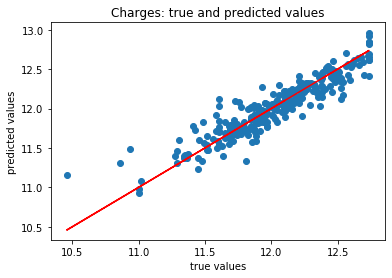

Mean absolute error of the prediction is: 0.10480976347159383
Mean squared error of the prediction is: 0.02150469668886451
Root mean squared error of the prediction is: 0.14664479768769334
Mean absolute percentage error of the prediction is: 0.8777274058015545


In [24]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, Y3, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

# We add constant to the model as it's a best practice
# to do so every time!
X3_test = sm.add_constant(X3_test)

# We are making predictions here
y3_preds = results.predict(X3_test)

plt.scatter(y3_test, y3_preds)
plt.plot(y3_test, y3_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y3_test, y3_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y3_test, y3_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y3_test, y3_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y3_test - y3_preds) / y3_test)) * 100))



The log transformation on our variable changed all metrics for the better. 

In [25]:
# Fitting a ridge regression model. Alpha is the regularization
# parameter (usually called lambda). As alpha gets larger, parameter
# shrinkage grows more pronounced.
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

ridgeregr = RidgeCV(alphas=alphas, cv=5) 
ridgeregr.fit(X3_train, y3_train)

# We are making predictions here
y3_preds_train = ridgeregr.predict(X3_train)
y3_preds_test = ridgeregr.predict(X3_test)

print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X3_train, y3_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X3_test, y3_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y3_test, y3_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y3_test, y3_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y3_test, y3_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y3_test - y3_preds_test) / y3_test)) * 100))


R-squared of the model on the training set is: 0.8430321333411145
-----Test set statistics-----
R-squared of the model on the test set is: 0.8545658660791849
Mean absolute error of the prediction is: 0.1054987555346132
Mean squared error of the prediction is: 0.021702969587435495
Root mean squared error of the prediction is: 0.14731927771827927
Mean absolute percentage error of the prediction is: 0.8835010008218125


In [26]:
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]
lassoregr = LassoCV(alphas=alphas, cv=5) 
lassoregr.fit(X3_train, y3_train)

# We are making predictions here
y3_preds_train = lassoregr.predict(X3_train)
y3_preds_test = lassoregr.predict(X3_test)

print("R-squared of the model on the training set is: {}".format(lassoregr.score(X3_train, y3_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lassoregr.score(X3_test, y3_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y3_test, y3_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y3_test, y3_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y3_test, y3_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y3_test - y3_preds_test) / y3_test)) * 100))


R-squared of the model on the training set is: 0.8430330136076564
-----Test set statistics-----
R-squared of the model on the test set is: 0.8546029247609866
Mean absolute error of the prediction is: 0.10548567055244272
Mean squared error of the prediction is: 0.021697439362704844
Root mean squared error of the prediction is: 0.14730050700084113
Mean absolute percentage error of the prediction is: 0.8833921353606226


In [27]:
elasticregr = ElasticNetCV(alphas=alphas, cv=5) 
elasticregr.fit(X3_train, y3_train)

# We are making predictions here
y3_preds_train = elasticregr.predict(X3_train)
y3_preds_test = elasticregr.predict(X3_test)

print("R-squared of the model on the training set is: {}".format(elasticregr.score(X3_train, y3_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(X3_test, y3_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y3_test, y3_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y3_test, y3_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y3_test, y3_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y3_test - y3_preds_test) / y3_test)) * 100))


R-squared of the model on the training set is: 0.8430343282499323
-----Test set statistics-----
R-squared of the model on the test set is: 0.8545748083756188
Mean absolute error of the prediction is: 0.10549706643577744
Mean squared error of the prediction is: 0.021701635138758887
Root mean squared error of the prediction is: 0.14731474854460053
Mean absolute percentage error of the prediction is: 0.8834849411083608


When looking at all the models I can say that the OLS regression is slightly better than lasso, ridge, or elastic regressions. Transforming the target variable to log made our fit work better as well.

In [28]:
#for fun I will add a variable that takes total sqaure footage times overallqual 
houseprices['total_sf_qual'] = (houseprices['totalbsmtsf'] + houseprices['firstflrsf'] + houseprices['secondflrsf']) * houseprices['overallqual']

In [32]:
Y3 = houseprices['log_saleprice']

X3 = houseprices[['total_sf_qual',
                  'overallqual',
                  'grlivarea',
                  'garagecars',
                  'totalbsmtsf',
                  'fullbath',
                  'yearbuilt',
                  'yearremodadd'] + dummy_columns_two]

#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)
X3 = sm.add_constant(X3)

results = sm.OLS(Y3, X3).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log_saleprice   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     920.5
Date:                Thu, 31 Oct 2019   Prob (F-statistic):               0.00
Time:                        18:30:40   Log-Likelihood:                 733.75
No. Observations:                1460   AIC:                            -1448.
Df Residuals:                    1450   BIC:                            -1395.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.2073      0.511      6.280      0.000       2.205       4.209
total_sf_qual -1.432e-05   1.97e-06     -7.271      0.000   -1.82e-05   -1.05e-05
overallqual       0.1134      0.007     15.605      0.000       0.099       0.128
grlivarea         0.0004   1.78e-05     21.535      0.000       0.000       0.000
garagecars        0.0696      0.007      9.638      0.000       0.055       0.084
totalbsmtsf       0.0003    1.8e-05     15.079      0.000       0.000       0.000
fullbath         -0.0249      0.010     -2.403      0.016      -0.045      -0.005
yearbuilt         0.0015      0.000      7.769      0.000       0.001       0.002
yearremodadd      0.0021      0.000      8.553      0.000       0.002       0.003
centralair_Y      0.1499      0.017      8.678      0.000       0.116       0.184
==============================================================================
Omnibus:                      275.944   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              869.195
Skew:                          -0.936   Prob(JB):                    1.81e-189
Kurtosis:                       6.283   Cond. No.                     2.46e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.46e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

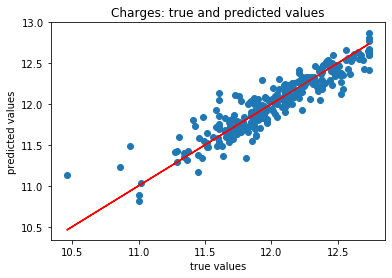

Mean absolute error of the prediction is: 0.10649896729937944
Mean squared error of the prediction is: 0.02173886690313875
Root mean squared error of the prediction is: 0.1474410624729039
Mean absolute percentage error of the prediction is: 0.8928261877164955


In [33]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, Y3, test_size = 0.2, random_state = 465)

X3_test = sm.add_constant(X3_test)

# We are making predictions here
y3_preds = results.predict(X3_test)

plt.scatter(y3_test, y3_preds)
plt.plot(y3_test, y3_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y3_test, y3_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y3_test, y3_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y3_test, y3_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y3_test - y3_preds) / y3_test)) * 100))



adding the extra variable actually increased our error in all categories. I don't think it adds any value to this model. 

I think adding the average apr for a 30 year fixed rate will let us see what the accurate pricing of a house will eventually be, and could change our model. Below you will see the formula for calculating interest over the life of the loan. 3.96% is the current avg loan apr and we divide that by 12 for the number of payments a year. That formula gives us the monthly payment and  we'll multiply it by 360 which is the number of payments over the life of the loan.  

In [59]:

avg_interest_payment = ((0.0032999999999999995 * (1.0032999999999999995**360)) / ((1.0032999999999999995**360) - 1))
Y4 = np.log((houseprices['saleprice'] * avg_interest_payment) * 360)

X4 = houseprices[['overallqual',
                 'grlivarea',
                 'garagecars',
                 'totalbsmtsf',
                 'fullbath',
                 'yearbuilt',
                 'yearremodadd'] + dummy_columns_two]

#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)
X4 = sm.add_constant(X4)

results = sm.OLS(Y4, X4).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     993.4
Date:                Sun, 03 Nov 2019   Prob (F-statistic):               0.00
Time:                        19:57:21   Log-Likelihood:                 707.61
No. Observations:                1460   AIC:                            -1397.
Df Residuals:                    1451   BIC:                            -1350.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            3.8911      0.519      7.493      0.000       2.872       4.910
overallqual      0.0725      0.005     15.473      0.000       0.063       0.082
grlivarea        0.0003   1.27e-05     22.924      0.000       0.000       0.000
garagecars       0.0689      0.007      9.387      0.000       0.055       0.083
totalbsmtsf      0.0002   1.23e-05     14.203      0.000       0.000       0.000
fullbath        -0.0233      0.011     -2.214      0.027      -0.044      -0.003
yearbuilt        0.0016      0.000      7.684      0.000       0.001       0.002
yearremodadd     0.0022      0.000      8.552      0.000       0.002       0.003
centralair_Y     0.0828      0.009      9.498      0.000       0.066       0.100
centralair_Y     0.0828      0.009      9.498      0.000       0.066       0.100
==============================================================================
Omnibus:                      381.991   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1738.342
Skew:                          -1.166   Prob(JB):                         0.00
Kurtosis:                       7.810   Cond. No.                     4.57e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.9e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

When looking at the OLS summary we can see that there is no difference. 

In [62]:
#looking at our best performing model so far
houseprices['log_saleprice'] = np.log(houseprices['saleprice'])

Y3 = houseprices['log_saleprice']

X3 = houseprices[['overallqual',
                 'grlivarea',
                 'garagecars',
                 'totalbsmtsf',
                 'fullbath',
                 'yearbuilt',
                 'yearremodadd'] + dummy_columns_two]

#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)
X3 = sm.add_constant(X3)

results = sm.OLS(Y3, X3).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log_saleprice   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     993.4
Date:                Sun, 03 Nov 2019   Prob (F-statistic):               0.00
Time:                        20:03:28   Log-Likelihood:                 707.61
No. Observations:                1460   AIC:                            -1397.
Df Residuals:                    1451   BIC:                            -1350.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            3.3544      0.519      6.459      0.000       2.336       4.373
overallqual      0.0725      0.005     15.473      0.000       0.063       0.082
grlivarea        0.0003   1.27e-05     22.924      0.000       0.000       0.000
garagecars       0.0689      0.007      9.387      0.000       0.055       0.083
totalbsmtsf      0.0002   1.23e-05     14.203      0.000       0.000       0.000
fullbath        -0.0233      0.011     -2.214      0.027      -0.044      -0.003
yearbuilt        0.0016      0.000      7.684      0.000       0.001       0.002
yearremodadd     0.0022      0.000      8.552      0.000       0.002       0.003
centralair_Y     0.0828      0.009      9.498      0.000       0.066       0.100
centralair_Y     0.0828      0.009      9.498      0.000       0.066       0.100
==============================================================================
Omnibus:                      381.991   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1738.342
Skew:                          -1.166   Prob(JB):                         0.00
Kurtosis:                       7.810   Cond. No.                     4.57e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.9e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

The number of observations in training set is 1168
The number of observations in test set is 292


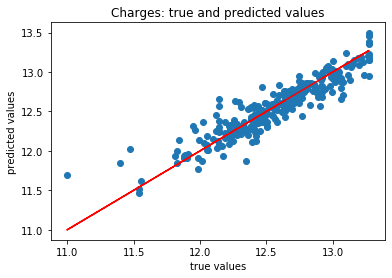

Mean absolute error of the prediction is: 0.10480976347158603
Mean squared error of the prediction is: 0.02150469668886381
Root mean squared error of the prediction is: 0.14664479768769095
Mean absolute percentage error of the prediction is: 0.8399104938419747


In [61]:
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, Y4, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X4_train.shape[0]))
print("The number of observations in test set is {}".format(X4_test.shape[0]))

# We add constant to the model as it's a best practice
# to do so every time!
X4_test = sm.add_constant(X4_test)

# We are making predictions here
y4_preds = results.predict(X4_test)

plt.scatter(y4_test, y4_preds)
plt.plot(y4_test, y4_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y4_test, y4_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y4_test, y4_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y4_test, y4_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y4_test - y4_preds) / y4_test)) * 100))



Overall I didn't see a huge difference in the two sets. The error did decrease slightly with houseprice being adjusted for mortgage costs.